# Gap-filling with ConvLSTM

**Author:** Yifei Hang (UW), Jiarui Yu (UW)

This notebook shows how to fit a basic ConvLSTM for filling the gaps in the Chlorophyll-a data. Although you can run this tutorial on CPU, it will be much faster on GPU. We used the image `quay.io/pangeo/ml-notebook:2024.08.18` for running the notebook.

In [1]:
import xarray as xr
import numpy as np

import dask.array as da

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D, Dropout

In [2]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'device_name': 'NVIDIA GeForce RTX 4070 Laptop GPU', 'compute_capability': (8, 9)}


In [3]:
zarr_ds = xr.open_zarr(store="./参考资料/2023_INTERN_MATERIAL/INDIAN_OCEAN_025GRID_DAILY.zarr", consolidated=True)  # get data

zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))  # choose long and lat

all_nan_CHL = np.isnan(zarr_sliced.CHL).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN

zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN

zarr_CHL = zarr_CHL.sortby('time')
zarr_CHL = zarr_CHL.sel(time=slice('2020-01-01', '2020-12-31'))
zarr_CHL

<xarray.Dataset> Size: 711MB
Dimensions:          (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 596B 32.0 31.75 31.5 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 724B 45.0 45.25 45.5 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 39MB dask.array<chunksize=(25, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

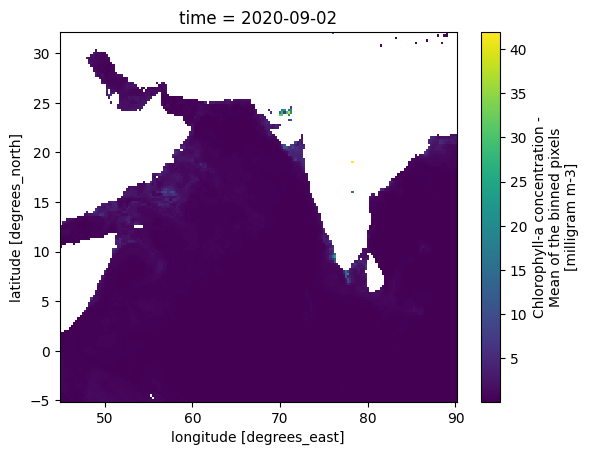

In [4]:
p = zarr_CHL.sel(time='2020-09-02').CHL.plot(y='lat', x='lon')

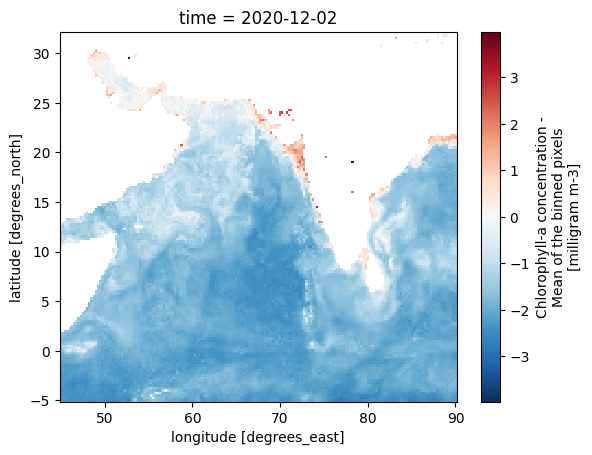

In [5]:
np.log(zarr_CHL.sel(time='2020-12-02').CHL).plot(y='lat', x='lon')

In [18]:
def log_label(data, label):
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

# Add more preprocessing later
def preprocess_data(data, features, label):
    # log CHL
    data_logged = log_label(data, label)

    # save all features and labels in one list
    sel_data_list = []
    for var in (features + [label]):
        sel_var_data = data_logged[var]
        sel_var_data = da.where(da.isnan(sel_var_data), 0.0, sel_var_data)
        sel_data_list.append(sel_var_data)

    # reassign datatype of list to dask array
    sel_data_da =  da.array(sel_data_list)
    # of dimensions (var, time, lat, lon)
    return sel_data_da


# 
def data_prep(data, window_size=5):
    X_orig = data
    y_orig = data[-1]
    
    X_orig = np.moveaxis(X_orig, 0, -1)
    length = X_orig.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(X_orig[i: i + window_size])
        y.append(y_orig[i + window_size])

    X, y = da.array(X), da.array(y)

    return X, y


def time_series_split(X, y, split_ratio):
    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train,
            X_val, y_val,
            X_test, y_test)
    


In [20]:
features = ['sst', 'so']  # Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
label = 'CHL'  # Curr Label: : chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

window_size = 5
X, y = data_prep(model_data, window_size=window_size)

split_ratio = [.7, .2, .1]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y, split_ratio)

In [12]:
y_train.shape

(252, 149, 181)

In [13]:
def create_model_ConvLSTM(input_shape=(5, 149, 181, 3)):
    model = Sequential()
    
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                         input_shape=input_shape,
                         padding='same', return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3),  
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     padding='same',
                     activation='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=1, 
                     kernel_size=(3, 3), 
                     padding='same', 
                     activation='linear'
                     ))
    
    return model

model = create_model_ConvLSTM()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 149, 181, 32)      40448     
                                                                 
 batch_normalization (BatchN  (None, 149, 181, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 149, 181, 32)      0         
                                                                 
 conv2d (Conv2D)             (None, 149, 181, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 149, 181, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 149, 181, 64)      0

In [14]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(8)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[early_stop])

Epoch 1/50
32/32 [==============================] - 13s 260ms/step - loss: 1.0611 - mae: 1.0611 - val_loss: 0.7293 - val_mae: 0.7293
Epoch 2/50
32/32 [==============================] - 8s 236ms/step - loss: 0.5555 - mae: 0.5555 - val_loss: 0.6904 - val_mae: 0.6904
Epoch 3/50
32/32 [==============================] - 8s 237ms/step - loss: 0.3589 - mae: 0.3589 - val_loss: 0.5267 - val_mae: 0.5267
Epoch 4/50
32/32 [==============================] - 8s 235ms/step - loss: 0.3039 - mae: 0.3039 - val_loss: 0.4278 - val_mae: 0.4278
Epoch 5/50
32/32 [==============================] - 8s 244ms/step - loss: 0.2711 - mae: 0.2711 - val_loss: 0.3880 - val_mae: 0.3880
Epoch 6/50
32/32 [==============================] - 8s 236ms/step - loss: 0.2492 - mae: 0.2492 - val_loss: 0.3104 - val_mae: 0.3104
Epoch 7/50
32/32 [==============================] - 8s 239ms/step - loss: 0.2358 - mae: 0.2358 - val_loss: 0.2944 - val_mae: 0.2944
Epoch 8/50
32/32 [==============================] - 8s 235ms/step - loss: 0

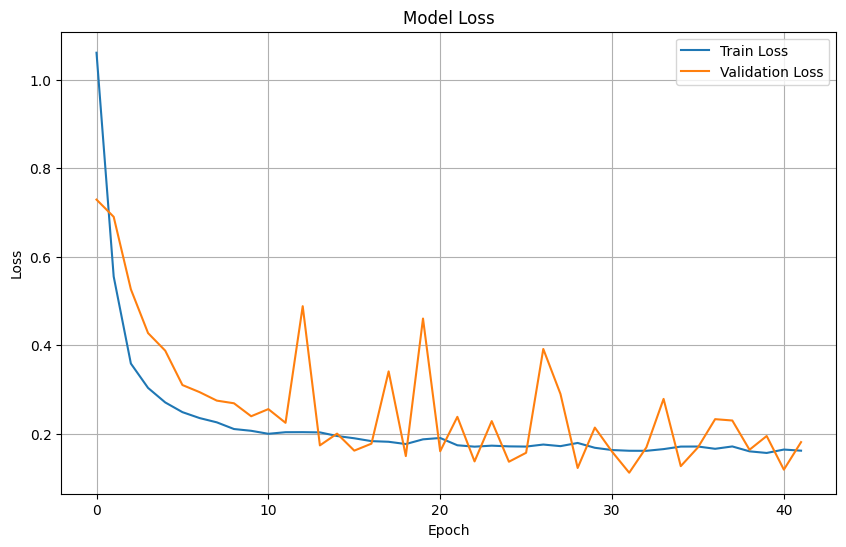

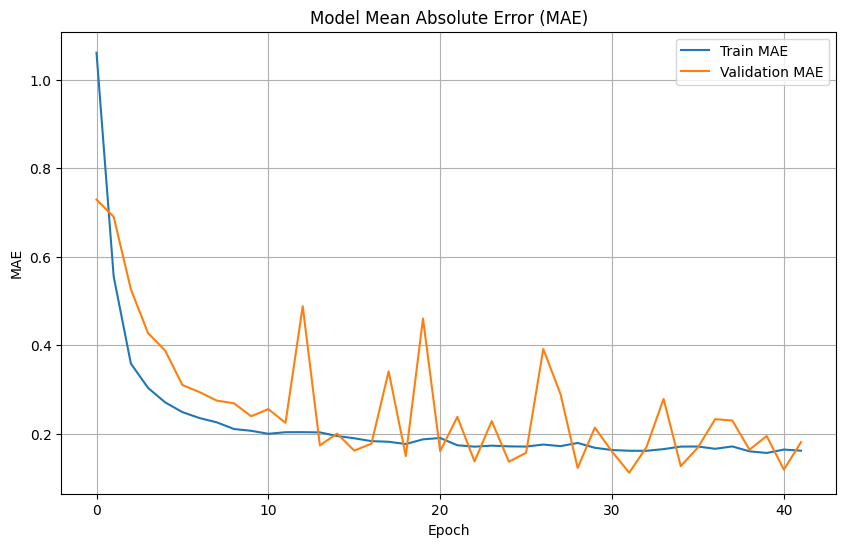

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [16]:
# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

10/10 [==============================] - 1s 56ms/step - loss: 0.1045 - mae: 0.1045
Test Loss: 0.10454108566045761
Test MAE: 0.1045411005616188


In [23]:
X

dask.array<stack, shape=(361, 5, 149, 181, 3), dtype=float32, chunksize=(1, 1, 149, 181, 1), chunktype=numpy.ndarray>

1/1 [==============================] - 0s 10ms/step


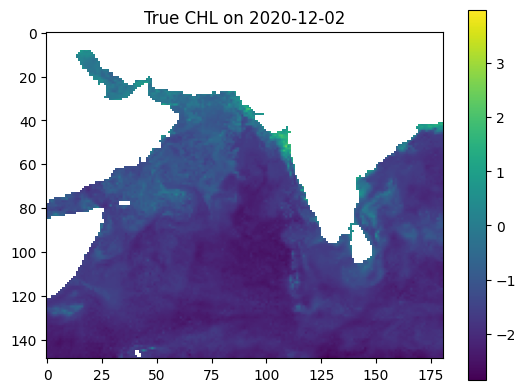

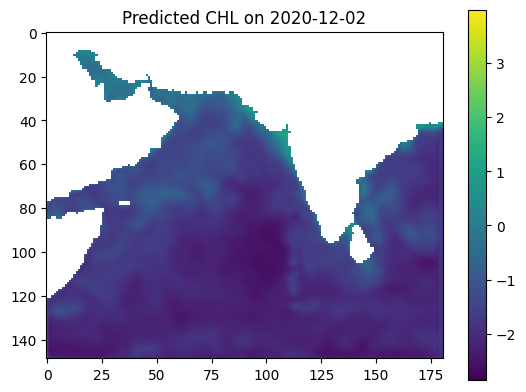

In [40]:
date_to_predict = '2020-12-02'
true_output = np.log(zarr_CHL.sel(time=date_to_predict).CHL)

date_index = (np.datetime64(date_to_predict) - np.datetime64('2020-01-01')).item().days
input = X[date_index - window_size]
input = np.array(input)
predicted_output = model.predict(input[np.newaxis, ...])[0]

predicted_output = predicted_output[:,:,0]

land_mask = np.load(r"E:\24SU Varanasi Intern\参考资料\2023_Intern_Material\land_mask_nc.npy")
predicted_output[land_mask] = np.nan

# true_output_2 = (model_data[-1])[date_index]

vmax = np.nanmax((true_output, predicted_output))
vmin = np.nanmin((true_output, predicted_output))

plt.imshow(true_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'True CHL on {date_to_predict}')
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f'Predicted CHL on {date_to_predict}')
plt.show()



In [41]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))


predicted_mae = compute_mae(np.array(true_output), predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

prev_day_dt64 = np.datetime64(date_to_predict) - np.timedelta64(1, 'D')
prev_day = np.datetime_as_string(prev_day_dt64, unit='D')
prev_day_CHL = np.log(zarr_CHL.sel(time=prev_day).CHL)
last_frame_mae = compute_mae(np.array(prev_day_CHL), np.array(true_output))
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

MAE between Predicted Output and True Output: 0.16125544905662537
MAE between Last Input Frame and True Output: 0.13173514604568481


In [33]:
input.shape
input[-1,:,:,-1].shape

(149, 181)

In [37]:
# t = numpy.datetime64('2012-06-30T20:00:00.000000000-0400')
# numpy.datetime_as_string(t, unit='D')
last_day = np.datetime64(date_to_predict) - np.timedelta64(1, 'D')
last_day_str = np.datetime_as_string(last_day, unit='D')
last_day_str

'2020-09-01'

In [31]:
# (np.datetime64('2020-01-03') - np.datetime64('2020-01-01')) / np.timedelta64(1, 'D')
(np.datetime64('2020-01-03') - np.datetime64('2020-01-01')).item().days

2